# All-pole model prior $p(x,y)$

## Model

Fourier transform convention: (same as Eq. 1 in FT wiki page):

$$ \tilde{f}(x) = \int f(t) e^{-2\pi i xt} dt $$

This is equivalent to choosing units Hz (or kHz) for $x$ rather than rad/s or rad/msec. See `test_core.ipynb` for more on this.

Impulse response for $K$ poles $p_k = -\pi y_k + 2\pi i x_k$:

$$ h(t; p) = (t \geq 0) \times \sum_{k=1}^K c_k e^{p_k t} + c_k^* e^{p_k^* t}$$

The coefficients are given by "the excluded pole product":

$$ c_k = \lim_{x \rightarrow p_k} (x - p_k) \tilde{h}(x; p) = {G \over \prod (p_k - p_1) (p_k - p_1^*) \ldots (p_k - p_k^*) \ldots (p_k - p_K) (p_k - p_K^*)} $$

where the gain $G = \prod_{k=1}^K |p_k|^2$ and $\tilde{h}(x; p)$ is defined below.

See @Arfken2005 for a reference on partial fraction expansions (PFEs). We
simply use the limit formula.

The formula for

$$p_k = -\pi y_k + 2\pi i x_k$$

comes from -3 dB bandwidth point and Fourier convention (since $x$ and $y$ are in kHz rather than rad/msec -- that's why we have to multiply by multiples of $\pi$). We use kHz for $p$ because $t$ is given in msec.

Transfer function: (Fourier transform of $h(t; p)$ with our convention)

$$ \tilde{h}(x; p) = {G \over \prod_{k=1}^K (2\pi i x - p_k)(2\pi i x - p_k^*)}$$

Note that the overall scale is determined by the DGF, so we normalize such that $h(0, p) = 1$.



## Do poles measure VTRs?

"Formants are easy to measure, VTRs aren't" @Whalen2022

In our view, poles are simply an expansion of the "true" transfer function. And we focus on formants, which are highly nonlinear functions of the poles.

Therefore, it is dangerous to identify them directly with VTRs, especially in such a simple linear approximation to the system (i.e., source-filter theory). For example, pole (resonance) amplitudes are not free parameters; they are determined by all the poles together -- this seems like a strong simplification: surely the resonance amplitude should be a free parameter? (For example by expanding the transfer function in a Gaussian mixture.)

Contra AP model:
- Less expressibility; a higher number of poles is necessary to emulate zeros
  in the transfer function...
- ... and the amplitudes and phases of the sinusoids are not independent; you need extra poles to control those. *This makes it even more clear that poles are just expansion terms*.
  > Indeed, learning that spectrum analysis problems can be formulated in AR terms amounts to little more than discovering the Mittag-Leffler theorem of complex variable theory (under rather general conditions an analytic function is determined by its poles and residues). [@Jaynes1987, p. 3]

**Nevertheless**, if one wants to measure VTRs, the way one would do this is full Bayesian model selection for the number of poles $K(D)$, ($D$ is the given data speech waveform) rather than assuming a fixed model $K = 16$. Then we can assume $K(D) \geq 3$, since the minimum amount of formants is 3, and those can be described in the simplest case by just 3 poles (and this would require that the formant amplitudes are indeed just functions of the 3 poles).

### PZ-model

The above paragraph assumed an AP (all-pole) model. But we could also contemplate a PZ (pole-zero) model where the amplitudes *are* free parameters (equivalent to introducing zeros, but easier because we can get a better prior and we don't have to calculate the partial fraction expansion and we have nested models for $A_k=0$).

In [2]:
%run init.ipy

from vtr.prior import bandwidth
from dgf import core
from lib import constants
from vtr.prior import allpole
from vtr import peak

2022-11-11 14:49:46.626892: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory


[Memory]3.0s, 0.0min    : Loading get_aplawd_training_pairs...


[Memory]18.0s, 0.3min   : Loading run_nested...
[Memory]19.5s, 0.3min   : Loading run_nested...
[Memory]20.9s, 0.3min   : Loading run_nested...
[Memory]22.4s, 0.4min   : Loading run_nested...
[Memory]22.5s, 0.4min   : Loading get_aplawd_training_pairs...


[Memory]26.3s, 0.4min   : Loading get_vtrformants_training_data...
[Memory]34.6s, 0.6min   : Loading run_nested...
[Memory]35.6s, 0.6min   : Loading run_nested...
[Memory]36.5s, 0.6min   : Loading run_nested...
[Memory]37.5s, 0.6min   : Loading run_nested...
[Memory]37.5s, 0.6min   : Loading get_vtrformants_training_data...


## Check AP power spectrum

In [20]:
prior = bandwidth.TFB_prior()

[Memory]305.1s, 5.1min  : Loading get_vtrformants_training_data...
[Memory]305.5s, 5.1min  : Loading run_nested...
[Memory]305.9s, 5.1min  : Loading run_nested...


[ 719.34217192 1096.3115748  2411.80709344]
[34.90910398 60.61737579 67.88807053]


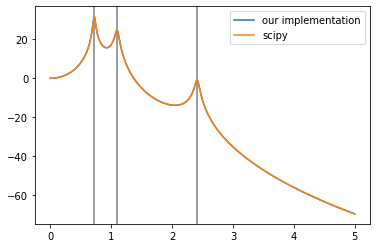

In [32]:
T, *xy = prior.sample(seed=jaxkey())
xy = np.array(xy)
x, y = np.split(xy, 2)

print(x)
print(y)

poles = core.make_poles(y, x) # rad kHz

f = np.linspace(0, constants.FS_KHZ/2, 500)
power = jax.jit(allpole.transfer_function_power_dB)(f, poles)

plot(f, power, label="our implementation")
for xi in x: axvline(xi/1000, color="grey")

##
import scipy.signal

p = hstack([poles, conj(poles)])*1000
k = prod(abs(p))

w, H = scipy.signal.freqresp(([], p, k), 2*pi*f*1000)
plot(f, 20*log10(abs(H)), label="scipy")

legend();

## Peak mergers in our TFB prior

About 15% of the power spectra of of samples from the TFB prior contain merged peaks (always F1 and F2).

We can apply rejection sampling to get rid of these.

CPU times: user 24.8 s, sys: 0 ns, total: 24.8 s
Wall time: 24.8 s


(array([141.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 859.]),
 array([2. , 2.1, 2.2, 2.3, 2.4, 2.5, 2.6, 2.7, 2.8, 2.9, 3. ]),
 <BarContainer object of 10 artists>)

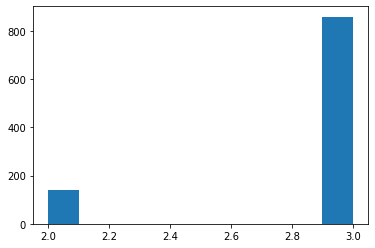

In [49]:
%%time
def sample_power_spectrum_dB(K=3, key=None):
    key = key if key is not None else jaxkey()
    f = constants.spectrum_frequencies()
    T, *xy = prior.sample(seed=key)
    xy = np.array(xy)
    x, y = np.split(xy, 2)
    x = x[:K]
    y = y[:K]
    poles = core.make_poles(y, x)
    power = allpole.transfer_function_power_dB(f/1000, poles)
    return f, x, y, power

def sample_K():
    f, x, y, power = sample_power_spectrum_dB(3, jaxkey())
    power = np.array(power)

    F, B = peak.get_formants_from_spectrum(
        f,
        power
    )
    
    K = len(F)
    return K

Ks = [sample_K() for _ in range(1000)]
hist(Ks)

## Try a fit

In [112]:
%%time
samples = allpole.get_TFB_samples()

[Memory]8078.6s, 134.6min: Loading get_vtrformants_training_data...
[Memory]8079.0s, 134.6min: Loading run_nested...
[Memory]8079.3s, 134.7min: Loading run_nested...


/home/marnix/WRK/thesis/py/vtr/prior/allpole.py:47: UserWarning: Rejected TFB sample that had merged peaks in its power spectrum
  warnings.warn("Rejected TFB sample that had merged peaks in its power spectrum")


CPU times: user 2.05 s, sys: 28.2 ms, total: 2.08 s
Wall time: 2 s


{'T': DeviceArray(5.3037828, dtype=float64),
 'F': array([ 506.8780885 , 1463.55127975, 2809.3056993 ]),
 'B': array([ 54.45436187,  72.8567662 , 239.30629735]),
 'f': array([0.000e+00, 1.000e+00, 2.000e+00, ..., 4.997e+03, 4.998e+03,
        4.999e+03]),
 'power': DeviceArray([ 0.00000000e+00,  3.86580176e-05,  1.54632849e-04, ...,
              -6.68888418e+01, -6.69012257e+01, -6.69136061e+01],            dtype=float64)}

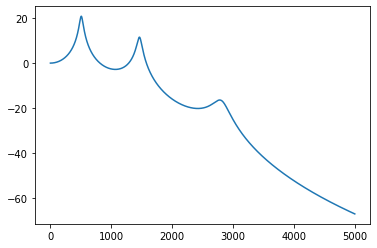

In [173]:
sample = samples[5]

plot(sample['f'], sample['power'])
sample

In [258]:
import dynesty
from vtr.prior import pareto
from allpole import *

K = 5

alpha = 5/4
beta = 1.

x0 = 100.
xmax = constants.FS_HZ/2
xbar = x0 + (xmax - x0)/(K+1)*np.arange(1, K+1)
pareto_F = np.array([x0, *xbar])

band_bounds = (np.array([20.]*K),
               np.array([constants.FS_HZ/2]*K))

sigma_F = np.array([2., 7, 29])
sigma_B = np.array([4., 14, 58])

def unpack(params):
    rho, h = params[:2]
    x, y = np.split(params[2:], 2)
    return rho, h, x, y

def loglike(
    params,
    f = sample['f'],
    F_true = sample['F'],
    B_true = sample['B']
):
    rho, h, x, y = unpack(params)
    
    if np.any(x >= constants.FS_HZ/2):
        return -np.inf
    
    poles = core.make_poles(y, x)
    power = transfer_function_power_dB(f/1000, poles)
    
    try:
        F, B = peak.get_formants_from_spectrum(
            f, power, rho, h
        )
    except np.linalg.LinAlgError:
        return -np.inf
    
    if len(F) != 3:
        return -np.inf
    
    F_err = np.sum(((F - F_true)/sigma_F)**2)
    B_err = np.sum(((B - B_true)/sigma_B)**2)
    
    return -(F_err + B_err)/2

def ptform(
    u,
    rho_prior = scipy.stats.beta(alpha, beta),
    h_prior = scipy.stats.expon(1.)
):
    us = unpack(u)
    rho = rho_prior.ppf(us[0])
    h = h_prior.ppf(us[1])
    x = pareto.sample_x_ppf(us[2], K, pareto_F)
    y = pareto.sample_jeffreys_ppf(us[3], band_bounds)
    return np.concatenate(([rho, h], x, y))

ndim = 2 + 2*K

def run_nested(cacheid, samplerargs, runargs):
    seed = cacheid
    rng = np.random.default_rng(seed)
    sampler = dynesty.NestedSampler(
        loglike, ptform, ndim=ndim,
        rstate=rng, **samplerargs
    )
    sampler.run_nested(**runargs)
    return sampler.results

SAMPLERARGS = {'sample': 'rslice', 'bootstrap': 10, 'nlive': ndim*5}
RUNARGS = {'save_bounds': False, 'maxcall': int(3e5)}

results = run_nested(1211111, SAMPLERARGS, RUNARGS)

1512it [12:53,  1.95it/s, +60 | bound: 72 | nc: 1 | ncall: 131840 | eff(%):  1.193 | loglstar:   -inf < -0.451 <    inf | logz: -22.763 +/-    nan | dlogz:  0.001 >  0.069]    


In [344]:
result = allpole.fit_FBT_sample(samples[17], 3, 11111)

[Memory]16782.5s, 279.7min: Loading run_nested...


Summary
nlive: 60
niter: 1512
ncall: 131780
eff(%):  1.193
logz: -22.763 +/-  0.589


None

'Information (bans)'

7.484047979294893

Quantiles:
rho [(0.025, 0.6018798179632736), (0.5, 0.7474702797063438), (0.975, 0.9304955022468634)]
Quantiles:
h [(0.025, 1.195777618742427), (0.5, 1.3659041130191625), (0.975, 1.9579864341918873)]
Quantiles:
x [(0.025, 347.86344353301763), (0.5, 503.94817479243966), (0.975, 508.5744825728586)]
Quantiles:
x [(0.025, 507.03380050977364), (0.5, 653.6187767087779), (0.975, 775.1523241661391)]
Quantiles:
x [(0.025, 624.1583523752887), (0.5, 939.5064839912827), (0.975, 1196.4088458320346)]
Quantiles:
x [(0.025, 1451.9588250788843), (0.5, 1467.7900001152152), (0.975, 1482.4526749705353)]
Quantiles:
x [(0.025, 2758.6196852597996), (0.5, 2818.7056269444124), (0.975, 2898.1047071361063)]
Quantiles:
y [(0.025, 47.10618555221839), (0.5, 54.740997053951155), (0.975, 125.74438051089295)]
Quantiles:
y [(0.025, 45.960198165219616), (0.5, 294.9712166592445), (0.975, 532.3406271335386)]
Quantiles:
y [(0.025, 149.84679868654922), (0.5, 266.5441733525187), (0.975, 430.68921091413335)]
Quantiles:
y [(0.0

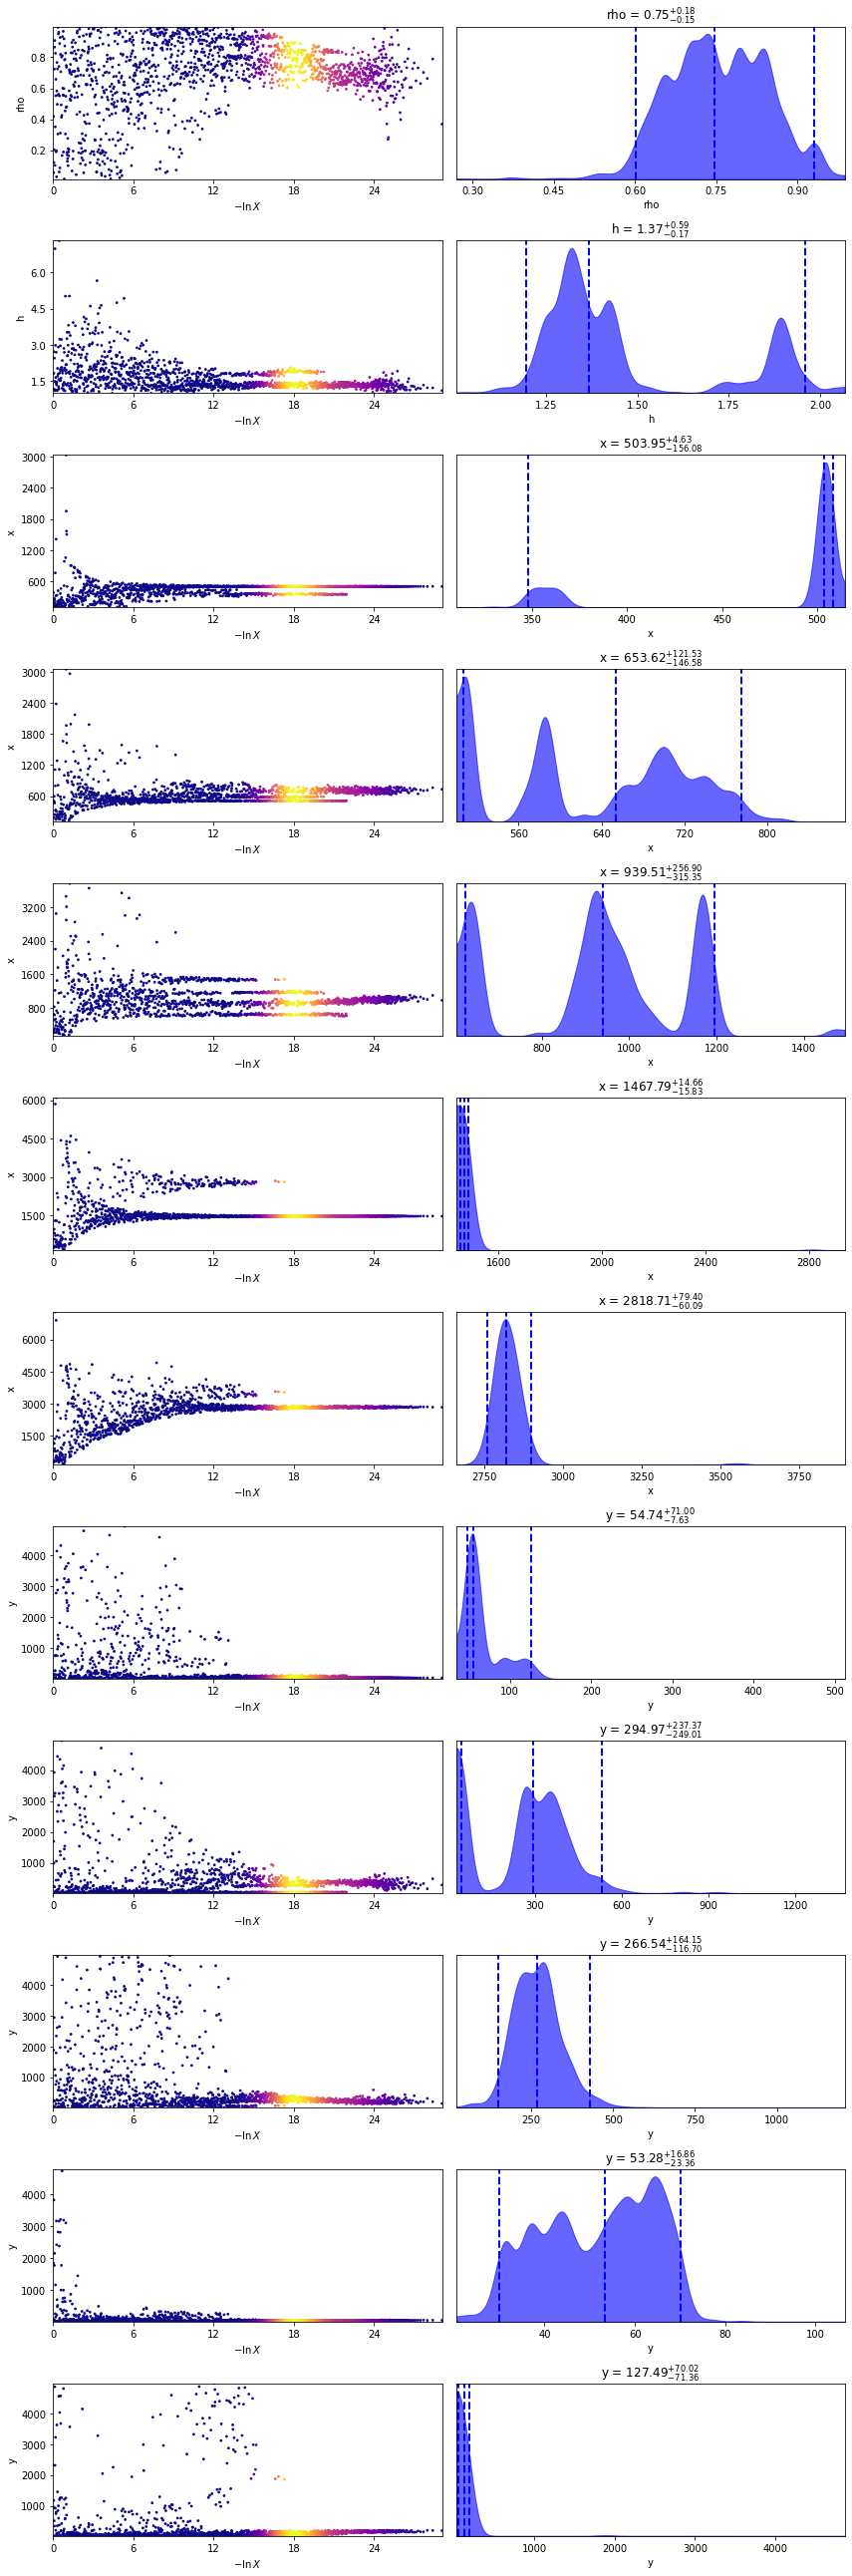

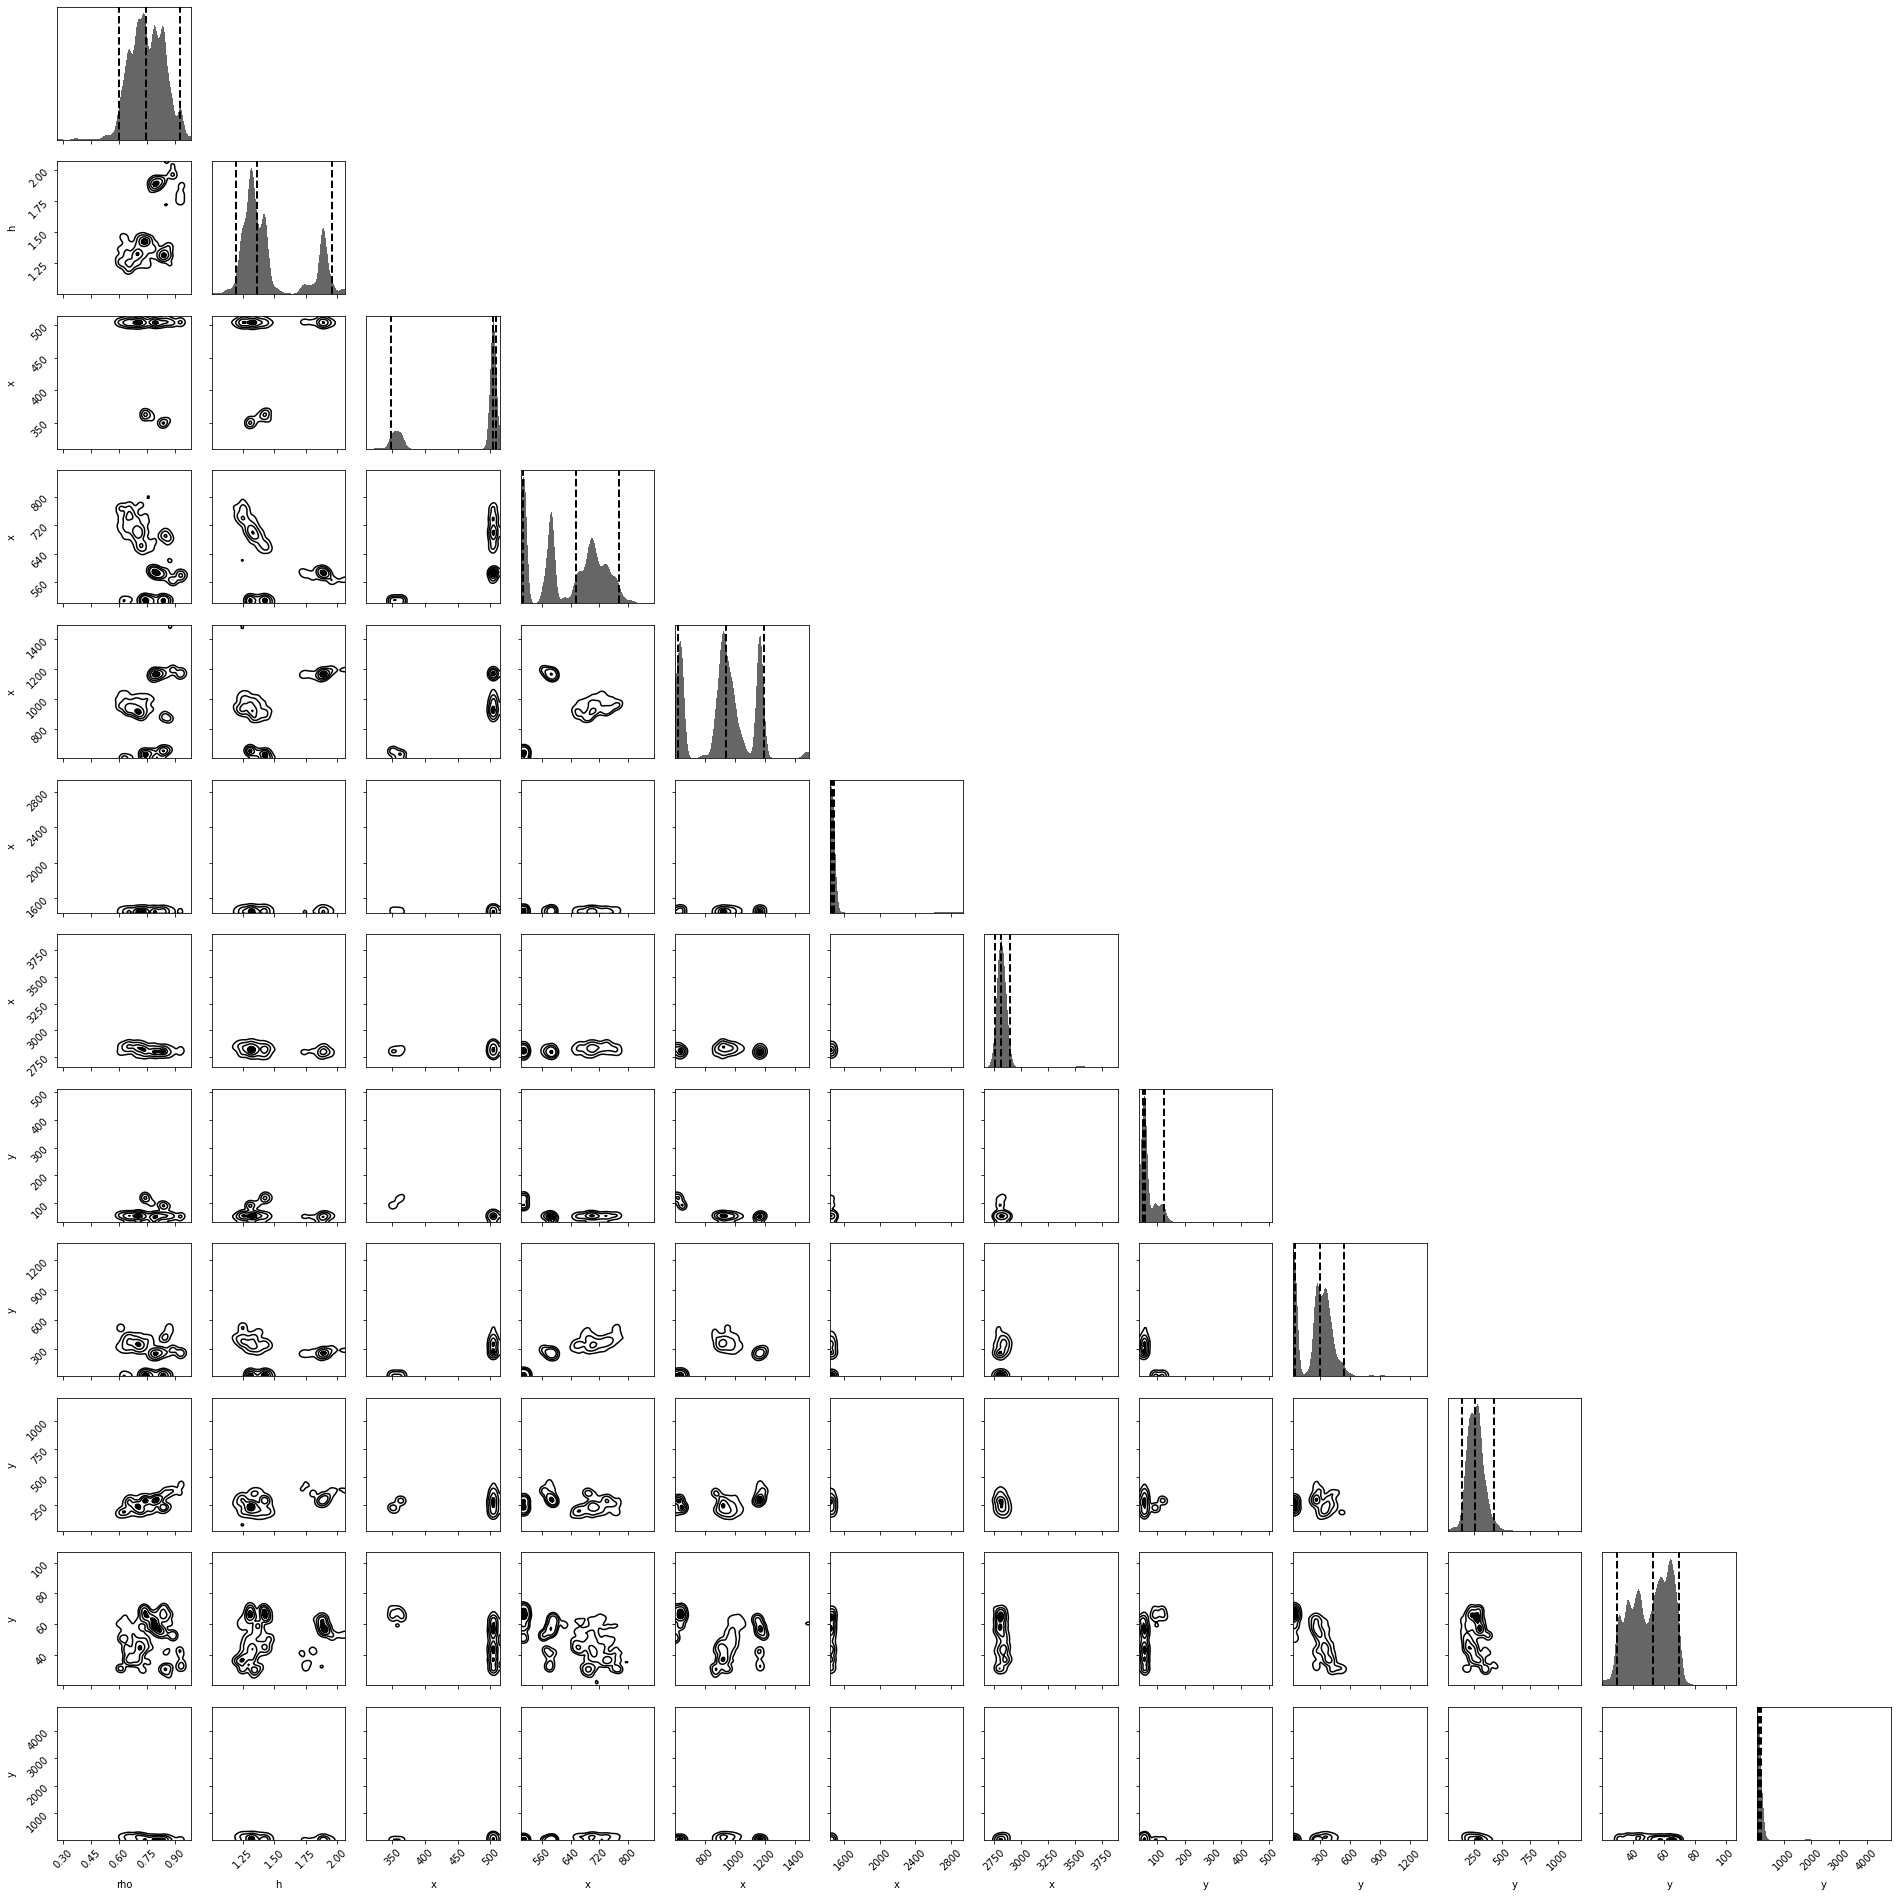

In [345]:
from lib import util

util.dyplot(results, ("rho", "h", *["x"]*K, *["y"]*K)); # (1.25, 1)

In [346]:
unpack(results.samples[-1,:])

(0.36867690614137777,
 1.1129699434245783,
 array([ 504.5473406 ,  732.89024542,  976.11645283, 1468.79951306,
        2830.29336845]),
 array([ 54.6737453 , 284.86570811, 147.04740515,  63.7917828 ,
        191.16700625]))

[0.1219115  8.44872025 9.6943007 ]
[ 2.71464575 -5.4084626  33.63834907]
[ -0.8780885    8.44872025 -23.3056993 ]
[  -6.97358521   -2.30187127 -155.79601421]
[0.1219115  8.44872025 9.6943007 ]
[ 2.71464575 -5.4084626  33.63834907]


-1.2592029623954564

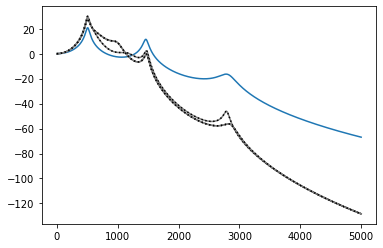

In [347]:
plot(sample['f'], sample['power'])

def loglike_debug(
    params,
    f = sample['f'],
    F_true = sample['F'],
    B_true = sample['B']
):
    rho, h, x, y = unpack(params)
    
    poles = core.make_poles(y, x)
    power = transfer_function_power_dB(f/1000, poles)
    
    plot(f, power, "grey")
    
    try:
        F, B, context = peak.get_formants_from_spectrum(
            f, power, rho, h, return_full=True
        )
    except np.linalg.LinAlgError:
        return -np.inf
    
    plot(f, context['smoothed'], ":", color="black")
    
    if len(F) != 3:
        return -np.inf
    
    print(F - F_true)
    print(B - B_true)
    
    F_err = np.sum(((F - F_true)/sigma_F)**2)
    B_err = np.sum(((B - B_true)/sigma_B)**2)
    
    return -(F_err + B_err)/2

loglike_debug(util.resample_equal(results, 1).squeeze())
loglike_debug(util.resample_equal(results, 1).squeeze())
loglike_debug(util.resample_equal(results, 1).squeeze())

In [349]:
from dgf import bijectors

post_samples = util.resample_equal(results, 100)[:,2:]

post_bounds = np.array([
    [(100., 5000.)]*K + [(20., 5000.)]*K,
]).squeeze()

b = bijectors.fit_nonlinear_coloring_bijector(
    post_samples, post_bounds, 123456789000
)

________________________________________________________________________________
[Memory] Calling dgf.bijectors.run_nested...
run_nested(123456789000, {'nlive': 50}, {'save_bounds': False})


1802it [00:12, 139.33it/s, +50 | bound: 206 | nc: 1 | ncall: 50063 | eff(%):  3.703 | loglstar:   -inf < -4582.884 <    inf | logz: -4615.729 +/-  0.760 | dlogz:  0.001 >  0.059]

______________________________________________________run_nested - 13.5s, 0.2min


[ 433.5339124   654.87895435  815.24513017 1481.99876551 2809.29979856]
[ 62.64348314 188.19681025 271.6763769   48.24847208 117.48457531]


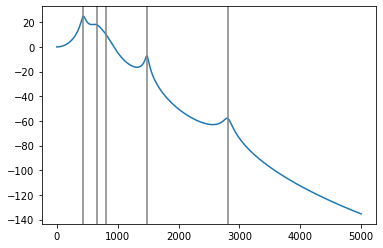

In [354]:
xy = b.forward(randn(2*K))
x, y = np.split(xy, 2)

print(x)
print(y)

poles = core.make_poles(y, x) # rad kHz

f = constants.spectrum_frequencies()
power = jax.jit(allpole.transfer_function_power_dB)(f/1000, poles)

plot(f, power, label="our implementation")
for xi in x: axvline(xi, color="grey")

In [357]:
allpole.get_fitted_FBT_samples()

[Memory]17153.0s, 285.9min: Loading get_vtrformants_training_data...
[Memory]17153.3s, 285.9min: Loading run_nested...
[Memory]17153.8s, 285.9min: Loading run_nested...


/home/marnix/WRK/thesis/py/vtr/prior/allpole.py:55: UserWarning: Rejected TFB sample that had merged peaks in its power spectrum
  warnings.warn("Rejected TFB sample that had merged peaks in its power spectrum")


[Memory]17155.2s, 285.9min: Loading run_nested...
3 0 -17.57959839963282
________________________________________________________________________________
[Memory] Calling vtr.prior.allpole.run_nested...
run_nested(95934066, {'bootstrap': 10, 'nlive': 40, 'sample': 'rslice'}, {'maxcall': 300000, 'save_bounds': False})


12it [00:02,  3.56it/s, bound: 1 | nc: 52 | ncall: 685 | eff(%):  1.752 | loglstar:   -inf <   -inf <    inf | logz:   -inf +/-    nan | dlogz:    inf >  0.049]Traceback (most recent call last):
  File "/home/marnix/WRK/thesis/py/venv/lib/python3.8/site-packages/dynesty/dynesty.py", line 1027, in __call__
    return self.func(x.copy(), *self.args, **self.kwargs)
  File "/home/marnix/WRK/thesis/py/vtr/prior/allpole.py", line 136, in ptform
    rho = rho_prior.ppf(us[0])
  File "/home/marnix/WRK/thesis/py/venv/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py", line 465, in ppf
    return self.dist.ppf(q, *self.args, **self.kwds)
  File "/home/marnix/WRK/thesis/py/venv/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py", line 2155, in ppf
    cond0 = self._argcheck(*args) & (scale > 0) & (loc == loc)
  File "/home/marnix/WRK/thesis/py/venv/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py", line 968, in _argcheck
    cond = logical_and(cond, (a

Exception while calling prior_transform function:
  params: [0.12898841 0.41448176 0.8598717  0.78472051 0.74301695 0.19873852
 0.26558869 0.36673628]
  args: []
  kwargs: {}
  exception:
Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/home/marnix/WRK/thesis/py/venv/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3369, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_6034/2723279528.py", line 1, in <cell line: 1>
    allpole.get_fitted_FBT_samples()
  File "/home/marnix/WRK/thesis/py/vtr/prior/allpole.py", line 185, in get_fitted_FBT_samples
    return list(yield_fitted_FBT_samples())
  File "/home/marnix/WRK/thesis/py/vtr/prior/allpole.py", line 172, in yield_fitted_FBT_samples
    results = fit_FBT_sample(sample, K, cacheid)
  File "/home/marnix/WRK/thesis/py/vtr/prior/allpole.py", line 158, in fit_FBT_sample
    results = run_nested(cacheid, samplerargs, runargs)
  File "/home/marnix/WRK/thesis/py/venv/lib/python3.8/site-packages/joblib/memory.py", line 594, in __call__
    return self._cached_call(args, kwargs)[0]
  File "/home/marnix/WRK/thesis/py/venv/lib/python3.8/site-packages/joblib/memory.py", line 537, i